# Explortatory analysis 

Notebook for exploratory analysis on tetrode data in the mPFC of a rat doing the parametric working memory (PWM) task.

Session: `data_sdc_20190902_145404_fromSD`

Current data storage:
* raw .dat, .rec, .mda, .bin and preprocessed .bin files are located on scratch under ``

* sorted data is located on bucket `Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata`

* in a sorted folder: 
    * folder for each .bin bundle & cluster notes, matlab struct w/ spike info from scraped phy, matlab struct w/ behavior info scraped from bdata
    * in .bin bundle folder you will find curated kilosort output, mask info as npy and preprocessed .bin that was run

see [jbreda_PWM_ephys_analysis](https://github.com/Brody-Lab/jbreda_PWM_ephys_analysis) for more info on how this info was obtained


**TODO**
* spk struct --> data frame
* make utils.py
* turn df cell into function


## Libs & fxs

In [10]:
# libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as spio

In [157]:
def load_nested_mat(filename):
    """
    This function should be called instead of direct scipy.io.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects. From https://stackoverflow.com/questions
    /48970785/complex-matlab-struct-mat-file-read-by-python
    """

    def _check_vars(d):
        """
        Checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        """
        for key in d:
            if isinstance(d[key], matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
            elif isinstance(d[key], np.ndarray):
                d[key] = _toarray(d[key])
        return d

    def _todict(matobj):
        """
        A recursive function which constructs from matobjects nested dictionaries
        """
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _toarray(elem)
            else:
                d[strg] = elem
        return d

    def _toarray(ndarray):
        """
        A recursive function which constructs ndarray from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        """
        if ndarray.dtype != 'float64':
            elem_list = []
            for sub_elem in ndarray:
                if isinstance(sub_elem, matlab.mio5_params.mat_struct):
                    elem_list.append(_todict(sub_elem))
                elif isinstance(sub_elem, np.ndarray):
                    elem_list.append(_toarray(sub_elem))
                else:
                    elem_list.append(sub_elem)
            return np.array(elem_list)
        else:
            return ndarray

    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_vars(data)

## Behavior

In [262]:
beh_path = 'Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata\data_sdc_20190902_145404_fromSD\protocol_info.mat'
beh_dict = load_nested_mat(beh_path)
beh_dict = beh_dict['behS']
parsed_events_dict = beh_dict['parsed_events']

In [261]:
# initialize df
beh_df = pd.DataFrame()

# make any adjustments
prev_side_adj = np.roll(beh_dict['prev_side'],1) # n-1 trial info
prev_side_adj = np.where(prev_side_adj == 114, 'RIGHT', 'LEFT' )
prev_side_adj[0] = 'NaN' # trial 0 doesn't have a previous

# get n_trial length items into df
beh_df['hit_hist'] = beh_dict['hit_history']
beh_df['delay'] = beh_dict['delay']
beh_df['pair_hist'] = beh_dict['pair_history']
beh_df['correct_side'] = beh_dict['correct_side']
beh_df['prev_side'] = prev_side_adj
beh_df['aud1_sigma'] = beh_dict['aud1_sigma']
beh_df['aud2_sigma'] = beh_dict['aud2_sigma']
 
# initilize space    
c_poke = np.zeros((len(parsed_events_dict)))
hit_state = np.zeros((len(parsed_events_dict)))
aud1_time = np.zeros((len(parsed_events_dict)))
aud2_time = np.zeros((len(parsed_events_dict)))

# iterate over items from state matrix
for trial in range(len(parsed_events_dict)):
    
    # every trial has a center poke
    c_poke[trial] = parsed_events_dict[trial]['states']['cp'][0]
    
    # not all trials will have sound/hit time/etc, pull out info for hits
    if beh_df['hit_hist'][trial] == 1.0:
        
        hit_state[trial] = parsed_events_dict[trial]['states']['hit_state'][0]
        aud1_time[trial] = parsed_events_dict[trial]['waves']['stimAUD1'][0]
        aud2_time[trial] = parsed_events_dict[trial]['waves']['stimAUD2'][0]
    else:
        hit_state[trial] = float("NaN")
        aud1_time[trial] = float("NaN")
        aud2_time[trial] = float("NaN")

# add to df
beh_df['c_poke'] = c_poke
beh_df['hit_state'] = hit_state
beh_df['aud1_time'] = aud1_time
beh_df['aud2_time'] = aud2_time
 
beh_df

,hit_hist,delay,pair_hist,correct_side,prev_side,aud1_sigma,aud2_sigma,c_poke,hit_state,aud1_time,aud2_time
0,NaN,6,9,RIGHT,NaN,0.008904,0.007300,476.563229,NaN,NaN,NaN
1,NaN,4,4,RIGHT,RIGHT,0.053144,0.019683,479.869221,NaN,NaN,NaN
2,1.0,6,3,RIGHT,RIGHT,0.019683,0.007290,482.048223,490.309221,482.098232,488.499224
3,0.0,2,9,RIGHT,RIGHT,0.008904,0.007300,498.909227,NaN,NaN,NaN
4,1.0,2,6,LEFT,RIGHT,0.002700,0.007290,505.471227,509.341221,505.522228,507.922222
...,...,...,...,...,...,...,...,...,...,...,...
400,1.0,2,2,RIGHT,LEFT,0.007290,0.002700,5227.210220,5231.212228,5227.260225,5229.661221
401,1.0,2,12,LEFT,RIGHT,0.002704,0.007300,5241.322233,5245.159224,5241.373230,5243.773224
402,1.0,2,14,LEFT,LEFT,0.005985,0.007300,5251.930228,5255.634227,5251.980234,5254.381225
403,NaN,6,7,LEFT,LEFT,0.007290,0.019683,5261.118223,NaN,NaN,NaN


## Ephys 

In [160]:
spks_path = 'Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata\data_sdc_20190902_145404_fromSD\ksphy_clusters_foranalysis.mat'
spks_dict = spio.loadmat(spks_path, squeeze_me = True)
spks_dict = spks_dict['PWMspkS']

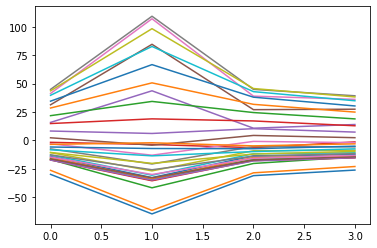

In [279]:
"proof of cell"

wave_snippet = spks_dict['waves_mn']

wave_snippet.sh